In [173]:
%matplotlib notebook

import numpy as np
import pandas as pd
import re
from collections import Counter
# import logging
# from time import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

import language_check

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict, cross_validate

from scipy.cluster.hierarchy import ward, dendrogram, linkage

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)


In [2]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.head()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computers have on people are great learning skills/affects...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit ou...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
essay_id          12976 non-null int64
topic             12976 non-null int64
essay             12976 non-null object
rater1_domain1    12976 non-null int64
rater2_domain1    12976 non-null int64
rater3_domain1    128 non-null float64
target_score      12976 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
topic2_target     1800 non-null float64
rater1_trait1     2292 non-null float64
rater1_trait2     2292 non-null float64
rater1_trait3     2292 non-null float64
rater1_trait4     2292 non-null float64
rater1_trait5     723 non-null float64
rater1_trait6     723 non-null float64
rater2_trait1     2292 non-null float64
rater2_trait2     2292 non-null float64
rater2_trait3     2292 non-null float64
rater2_trait4     2292 non-null float64
rater2_trait5     723 non-null float64
rater2_trait6     723 non-null float64
rater3_trait1     128

<IPython.core.display.Javascript object>


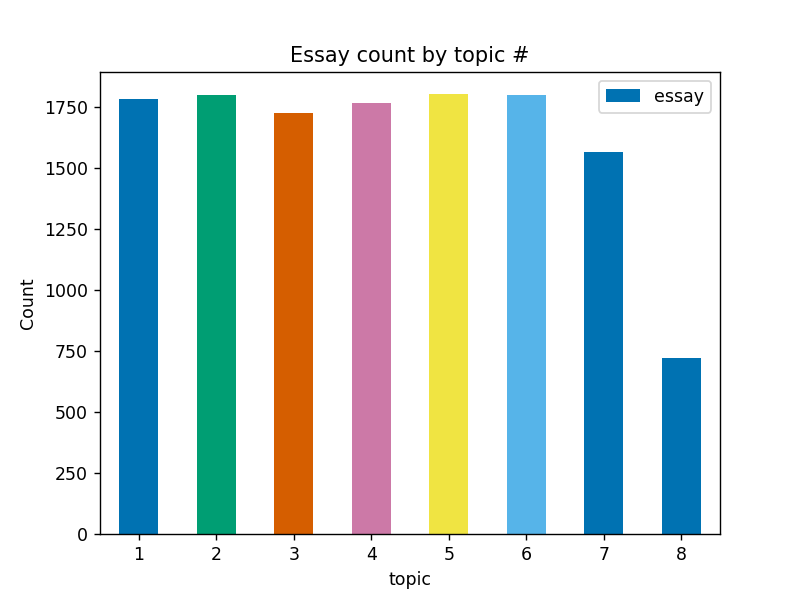

Text(0,0.5,'Count')

In [4]:
training_set.groupby('topic').agg('count').plot.bar(y='essay', rot=0)
plt.title('Essay count by topic #')
plt.ylabel('Count')


In [5]:
# Count characters and words for each essay
training_set['char_len'] = training_set['essay'].str.len()
training_set['word_count'] = training_set['essay'].str.strip().str.split('[\W_]+').str.len()

<IPython.core.display.Javascript object>


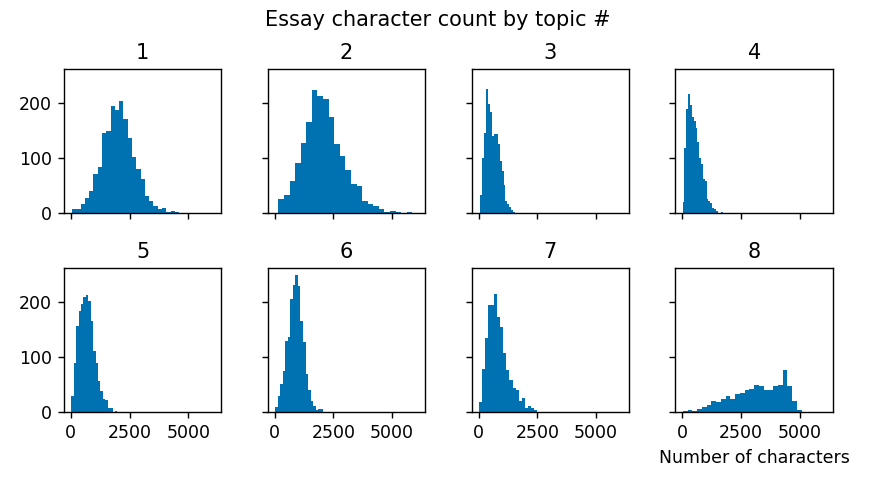

In [6]:
training_set.hist(column='char_len', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Essay character count by topic #')
plt.xlabel('Number of characters')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


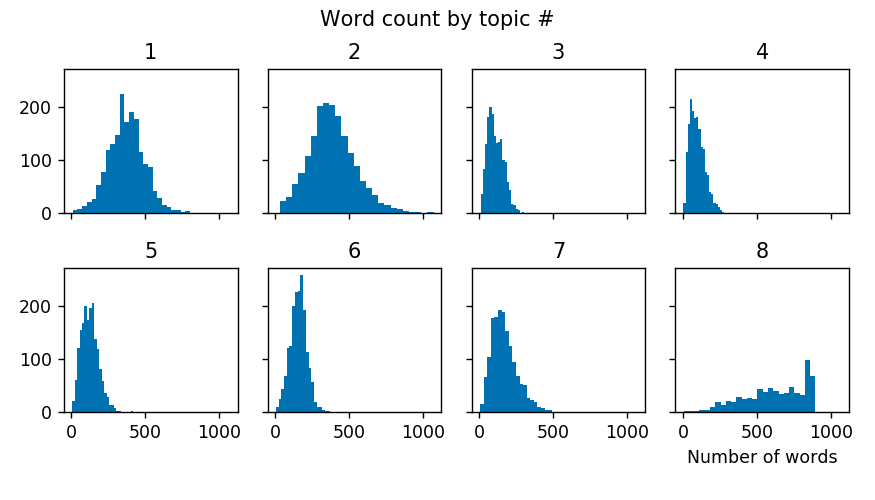

In [7]:
training_set.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
training_set.groupby(['topic'])['target_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
topic,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


<IPython.core.display.Javascript object>


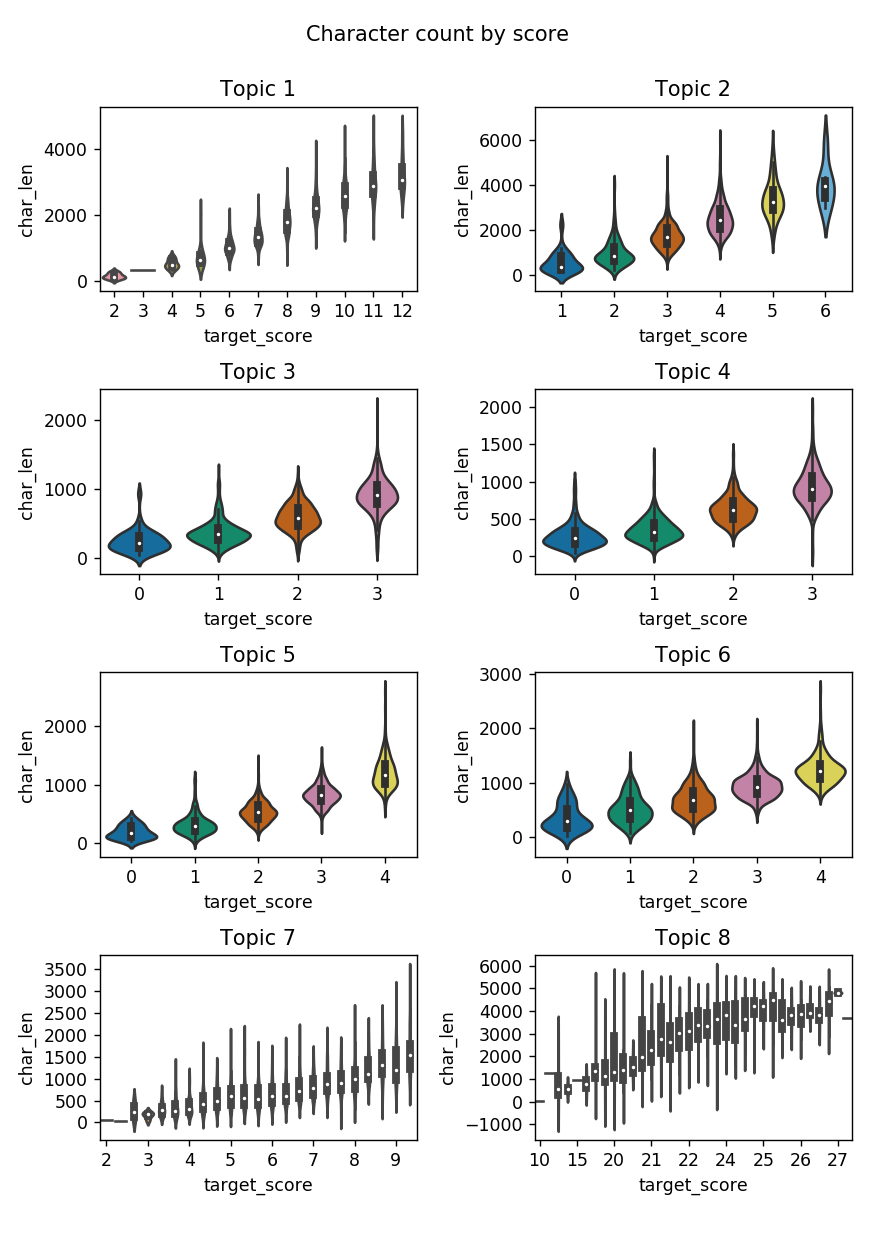

In [9]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='char_len', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Character count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


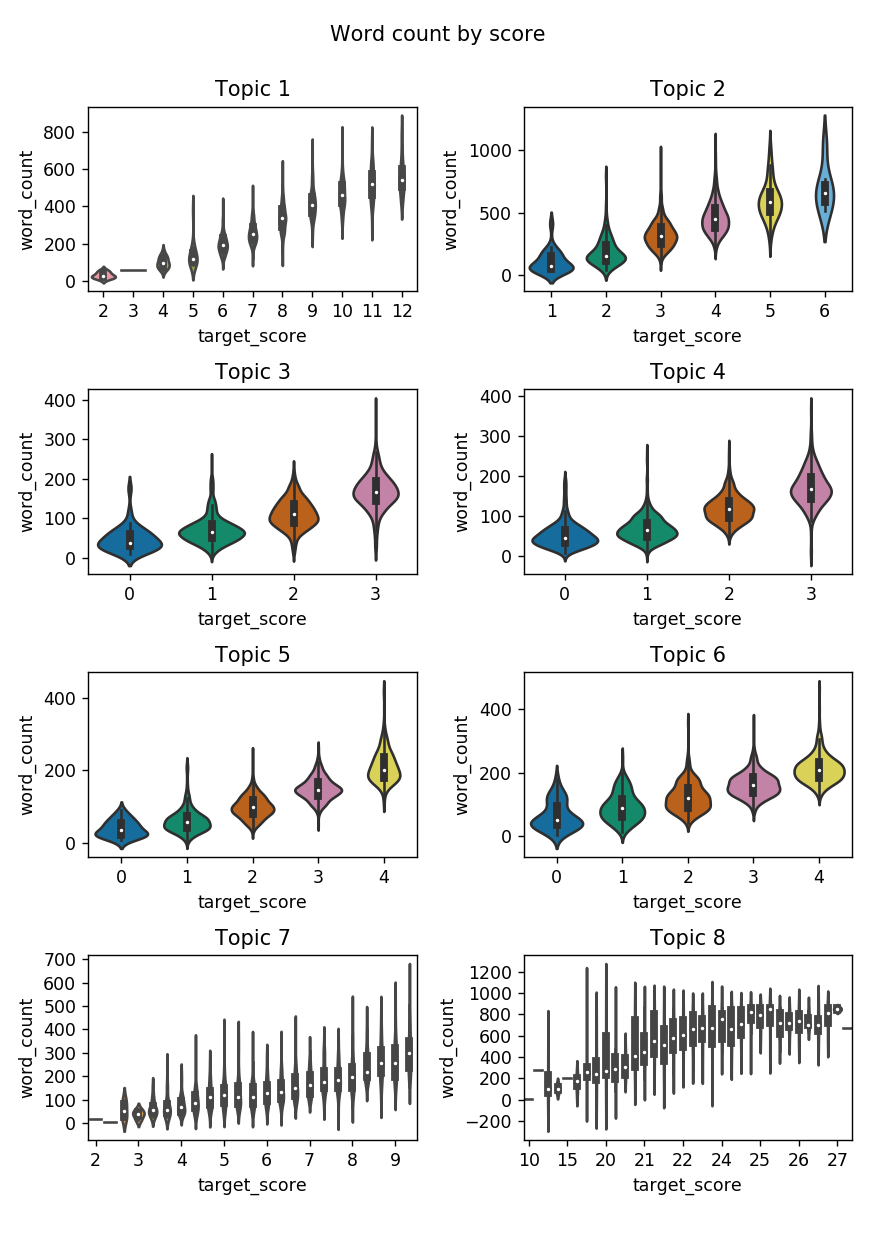

In [10]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='word_count', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


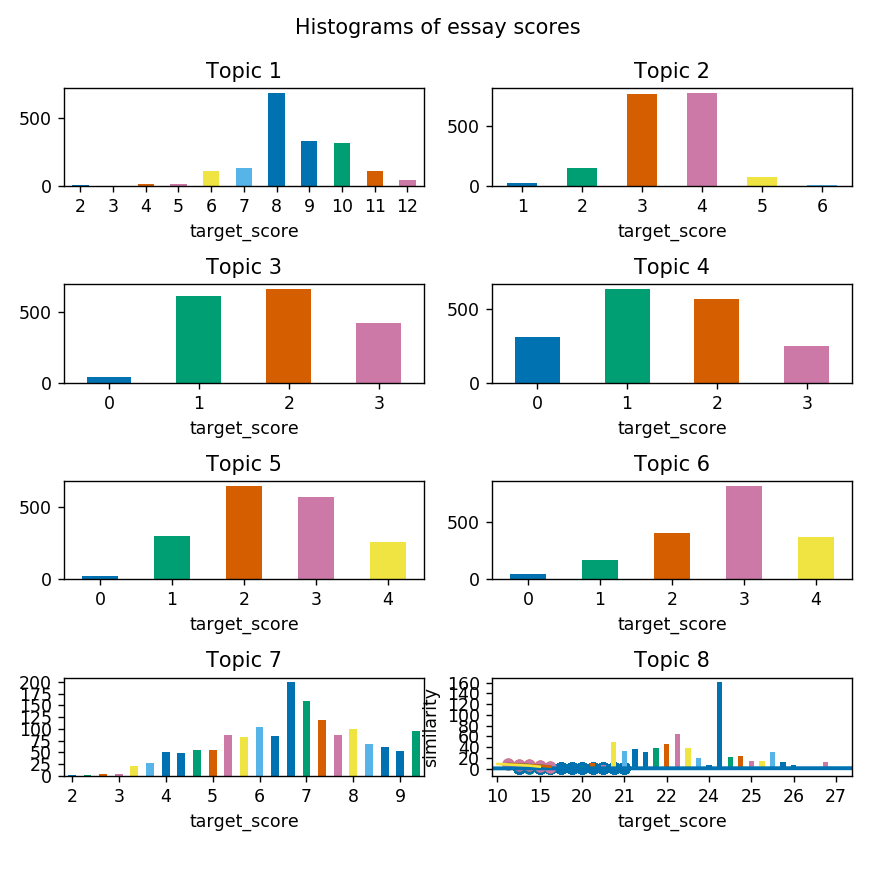

In [11]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7,7), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        training_set[training_set['topic'] == topic_number]\
            .groupby('target_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Essay processing:

1. Language correction with languagetool (add number of corrections as feature)
2. Sentence tokenization with Spacy
3. Sentence count and length
4. Word tokenize with Spacy
5. Word token classification (punctuation, stop words and anonymized entities, pos, ent)
6. Document similarity (based on arbitrary high scoring essay for each topic)

## Grammar and spelling

As to be expected with student essays, many essays exhibit grammar and spelling errors. 

Parts-of-speech (POS) and named-entity-recognition (NER) is hampered in part by the lack of consitent spelling and punctuation. Therefore, the essays will be corrected using languagetool and the nlp parsing will be performed with Spacy on the corrected essays.

In [12]:
text = 'Some people are still using Myspoce instead of facdbook'

Textblob is an open source nlp package and something to keep an eye on. Unlike Spacy, textblob includes a statistics based spell checker. It only claims 70% accuracy, and in my testing it didn't perform well.

https://textblob.readthedocs.io/en/dev/

In [13]:
from textblob import TextBlob
data = TextBlob(text)
print (data.correct())

Some people are still using Myspoce instead of facdbook


Languagetool.org has a python wrapper for spelling and grammatical errors at 
https://github.com/myint/language-check

It appears to work quite well, although it requires intermediate storage of a list of errors ('matches').

In [14]:
tool = language_check.LanguageTool('en-US')

matches = tool.check(text)
language_check.correct(text, matches)

'Some people are still using MySpace instead of Facebook'

In [15]:
text = training_set.essay[1871]
text

'I do think that there should be a censorship in not just in libaries, but everywhare.       Personlly, I think that the way that the libraries have the books are appropite and if the parents do not want thier children going any where  that is not privy to them keep a hand lenght away     As for the parents, the parents know the aera that intrest them ,therefor the parents should go there'

In [16]:

matches = tool.check(text)
language_check.correct(text, matches)


'I do think that there should be a censorship in not just in libraries, but everywhere.  Personally, I think that the way that the libraries have the books are appropriate and if the parents do not want their children going anywhere that is not privy to them keep a hand length away As for the parents, the parents know the area that interest them,therefor the parents should go there'

As seen in the last sentence, languagetool did not correct `",therefor"`. Nonetheless, it should be good enough to proceed.

In [17]:
"""
use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
Using language_check python wrapper for languagetool:
https://www.languagetool.org/dev
"""
tool = language_check.LanguageTool('en-US')

t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save work
training_set.to_pickle('training_corr.pkl')

Processing time: 0:14:49.229235


Here's a very special example of poor writing skills (or perhaps a digitization error?). None of the spell checkers I tried were able to make much sense out of this.

In [18]:
print('Original:')
print(training_set.essay[18])
print('Corrected with languagetool:')
print(training_set.corrected[18])

Original:
I aegre waf the evansmant ov tnachnolage. The evansmant ov tnachnolige is being to halp fined a kohar froi alnsas. Tnanchnolage waf ont ot we wod not go to the moon. Tnachnologe evans as we maech at. The people are in tnacholege to the frchr fror the good ov live. Famas invanyor ues tnacholage leki lena orde dvanse and his fling mashine. Tnachologe is the grat
Corrected with languagetool:
I Segre weigh the evansmant of tnachnolage. The evansmant of tnachnolige is being to half fined a coheir from Kansas. Tnanchnolage weigh Ont OT we won not go to the moon. Tnachnologe Evans as we match at. The people are in tnacholege to the arch for the good of live. Lamas inventor us tnacholage Levi Lena order dance and his fling machine. Tnachologe is the great


## NLP with Spacy

In [21]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(stopwords.words('english'))
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:10:21.884310


In [101]:
training_set.to_pickle('training_spacy.pkl')

In [24]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()

,tokens,pos,sents,ner
0,"[Dear, local, newspaper, ,, I, think, effects, computers, have, on, people, are, great, learning...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN, VERB, ADP, NOUN, VERB, ADJ, NOUN, NOUN, SYM, NOU...","[Dear local newspaper, I think effects computers have on people are great learning skills/affect...","[Facebook, MySpace, all day]"
1,"[Dear, @CAPS1, @CAPS2, ,, I, believe, that, using, computers, will, benefit, us, in, many, ways,...","[ADJ, PROPN, PUNCT, PUNCT, PRON, VERB, ADP, VERB, NOUN, VERB, VERB, PRON, ADP, ADJ, NOUN, ADP, V...","[Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking an...","[Facebook, MySpace, millions, one, MySpace, Facebook, one, millions, @MONTH1, @LOCATION2, A Mill..."
2,"[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, more, people, use, computers, ,, but, not, everyone...","[ADJ, PUNCT, PROPN, PUNCT, PROPN, ADJ, CCONJ, ADJ, NOUN, VERB, NOUN, PUNCT, CCONJ, ADV, NOUN, VE...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that thi...","[today, one, @CAPS4, one, @MONTH1, thousand, @ORGANIZATION1]"
3,"[Dear, Local, Newspaper, ,, @CAPS1, I, have, found, that, many, experts, say, that, computers, d...","[ADJ, PROPN, PROPN, PUNCT, PROPN, PRON, VERB, VERB, ADP, ADJ, NOUN, VERB, ADP, NOUN, VERB, ADV, ...","[Dear Local Newspaper, @CAPS1, I have found that many experts say that computers do not benefit ...","[Dear Local Newspaper, @PERSON1, @PERSON2, @CAPS4, @LOCATION2, @PERCENT3, @LOCATION1, A+, Newspa..."
4,"[Dear, @LOCATION1, ,, I, know, having, computers, has, a, positive, effect, on, people, ., The, ...","[ADJ, ADP, PUNCT, PRON, VERB, VERB, NOUN, VERB, DET, ADJ, NOUN, ADP, NOUN, PUNCT, DET, NOUN, VER...","[Dear @LOCATION1, I know having computers has a positive effect on people., The computers connec...","[First, @NUM1 hours, one, Mae, Secondly, @LOCATION2, one, one]"


### Generate numerical features from processed essays

In [98]:
"""Choose arbitrary essay from highest available target_score for each topic.
all other essays will be compared to these. 
The uncorrected essays will be used since the reference essays should have fewer errors.
"""
reference_essays = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340} # topic: essay_id

references = {}

t0 = datetime.now()

# generate nlp object for reference essays:
for topic, index in reference_essays.items():
    references[topic] = nlp(training_set.iloc[index]['essay'])

# generate document similarity for each essay compared to topic reference
training_set['similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references[row['topic']]), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:10:22.845150


<IPython.core.display.Javascript object>


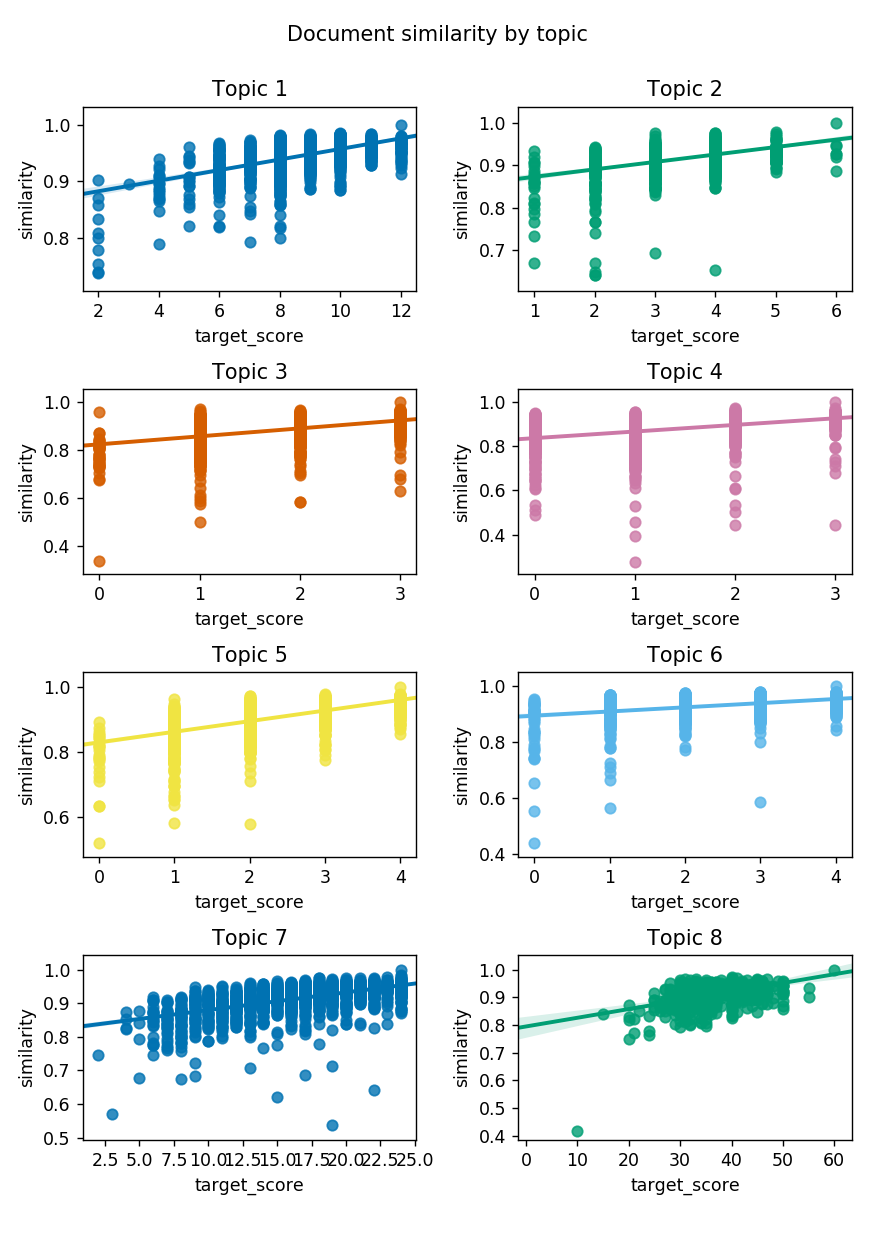

In [102]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.regplot(x='target_score', y='similarity', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Document similarity by topic')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Document similarity may prove to be ineffective for persuasive/narritive essays. The example below is the highest scored essay for topic 8. The author uses a unique creative style which is unlikely to be replicated.

In [53]:
training_set.iloc[12340]['essay']

' Bell rings.  Shuffle, shuffle. @CAPS1. Snap. EEEE. Crack. Slam. Click, stomp, @CAPS1. Tap tap tap. SLAM. Creak. Shoof, shoof.  Sigh. Seventh class of the day. Here we go. "@CAPS2! Tu va ou pas? On a +¬tude cette class-l+á. Tu peux aller au bibliotheque si tu veux...." @CAPS3 all blinked at me, @PERSON1, @NUM1le and @ORGANIZATION1, chocolate-haired and mocha skinned, impatiently awaiting my answer. The truth was, I knew @CAPS3 didn\'t really care if I came or not. It made no difference to them if I trailed a few feet behind like some pathetic puppy. I was silent but adorable, loved only because I was an @CAPS4. Because I spoke fidgety @CAPS5. Because I was the exchange student, because my translator and colorful clothes were so shocking for ten seconds, and were then forgotten about.  I was a flock of seagulls haircut. So why are you here? I thought. Why did you go on exchange at all? You are the complete opposite of everyone here. No one wants you. Just go home.  But my ego had a rea

In [140]:
# count various features

t0 = datetime.now()

training_set['token_count'] = training_set.apply(lambda x: len(x['tokens']), axis=1)
training_set['unique_token_count'] = training_set.apply(lambda x: len(set(x['tokens'])), axis=1)
training_set['nostop_count'] = training_set \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
training_set['sent_count'] = training_set.apply(lambda x: len(x['sents']), axis=1)
training_set['ner_count'] = training_set.apply(lambda x: len(x['ner']), axis=1)
training_set['comma'] = training_set.apply(lambda x: x['corrected'].count(','), axis=1)
training_set['question'] = training_set.apply(lambda x: x['corrected'].count('?'), axis=1)
training_set['exclamation'] = training_set.apply(lambda x: x['corrected'].count('!'), axis=1)
training_set['quotation'] = training_set.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
training_set['organization'] = training_set.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
training_set['caps'] = training_set.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
training_set['person'] = training_set.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
training_set['location'] = training_set.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
training_set['money'] = training_set.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
training_set['time'] = training_set.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
training_set['date'] = training_set.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
training_set['percent'] = training_set.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['cconj'] = training_set.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
training_set['adv'] = training_set.apply(lambda x: x['pos'].count('ADV'), axis=1)
training_set['det'] = training_set.apply(lambda x: x['pos'].count('DET'), axis=1)
training_set['propn'] = training_set.apply(lambda x: x['pos'].count('PROPN'), axis=1)
training_set['num'] = training_set.apply(lambda x: x['pos'].count('NUM'), axis=1)
training_set['part'] = training_set.apply(lambda x: x['pos'].count('PART'), axis=1)
training_set['intj'] = training_set.apply(lambda x: x['pos'].count('INTJ'), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:00:08.371601


In [150]:
# pattern = re.compile(r'(@ORGANIZATIONd)')
training_set.iloc[0]

essay_id                                                                                                                1
topic                                                                                                                   1
essay                 Dear local newspaper, I think effects computers have on people are great learning skills/affects...
rater1_domain1                                                                                                          4
rater2_domain1                                                                                                          4
rater3_domain1                                                                                                        NaN
target_score                                                                                                            8
rater1_domain2                                                                                                        NaN
rater2_domain2          

In [153]:
training_set.to_pickle('training_features.pkl')

<function matplotlib.pyplot.show(*args, **kw)>

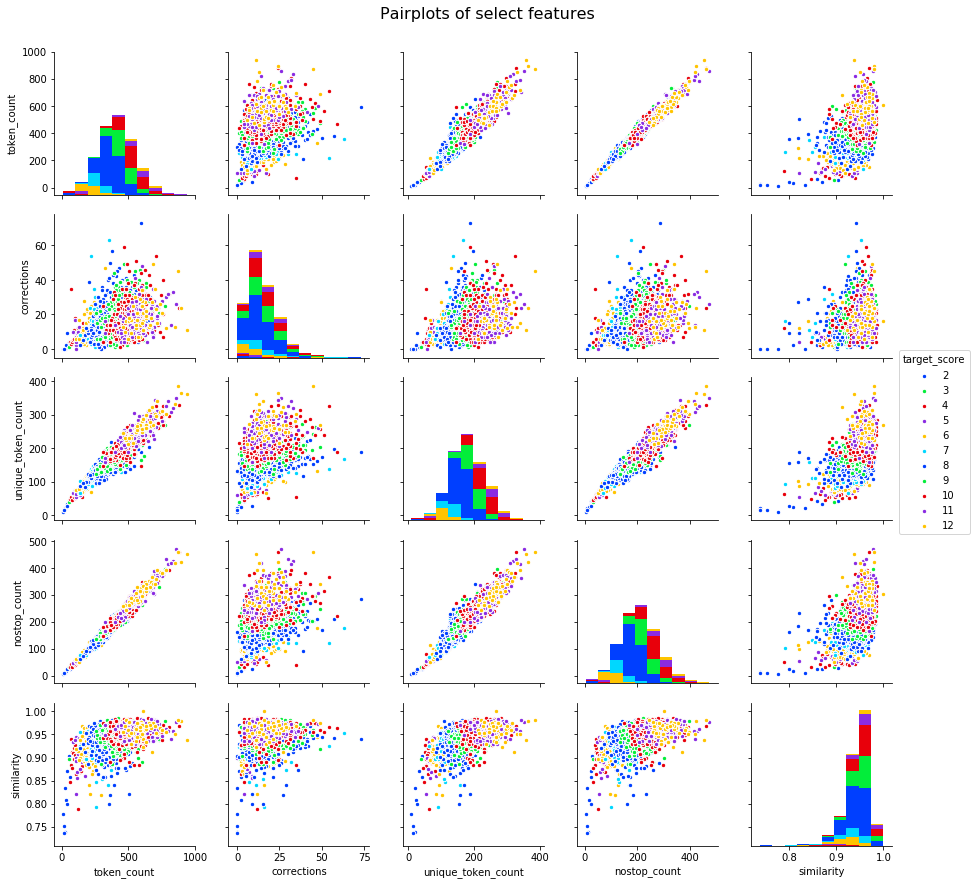

In [197]:
usecols = ['token_count', 'corrections', 'unique_token_count', 'nostop_count', 'similarity']
g = sns.pairplot(training_set[training_set.topic == 1], hue='target_score', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show

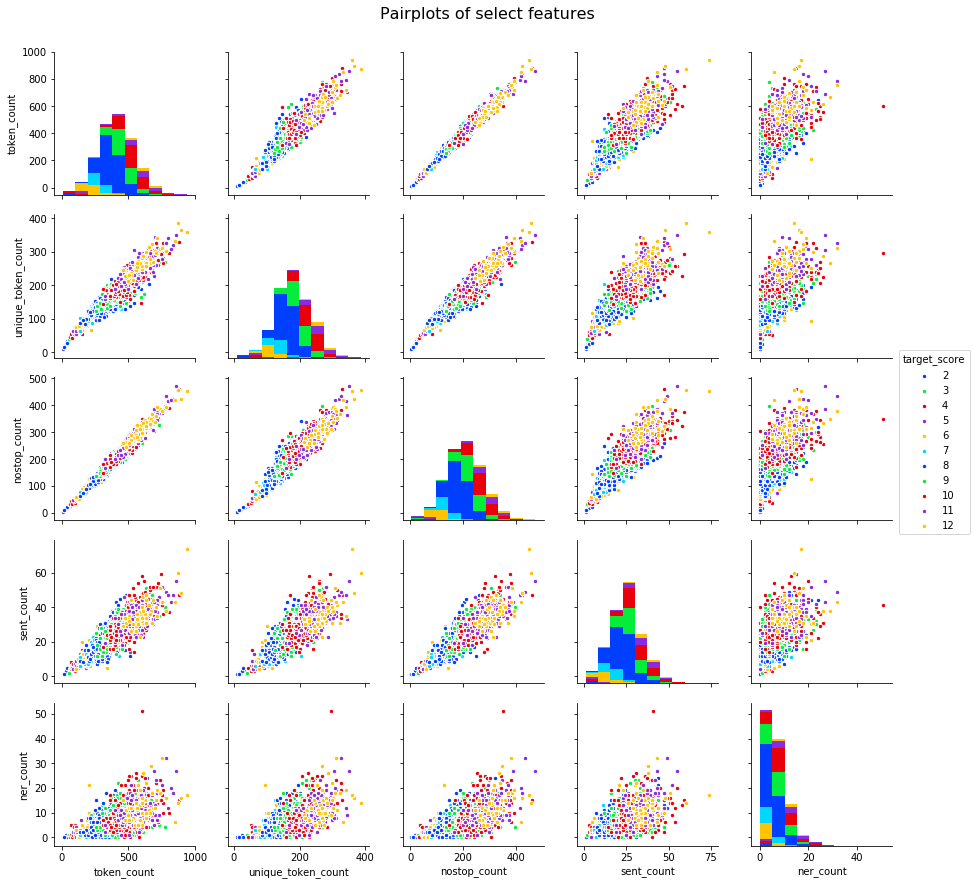

In [193]:
usecols = ['token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count']
g = sns.pairplot(training_set[training_set.topic == 1], hue='target_score', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show()

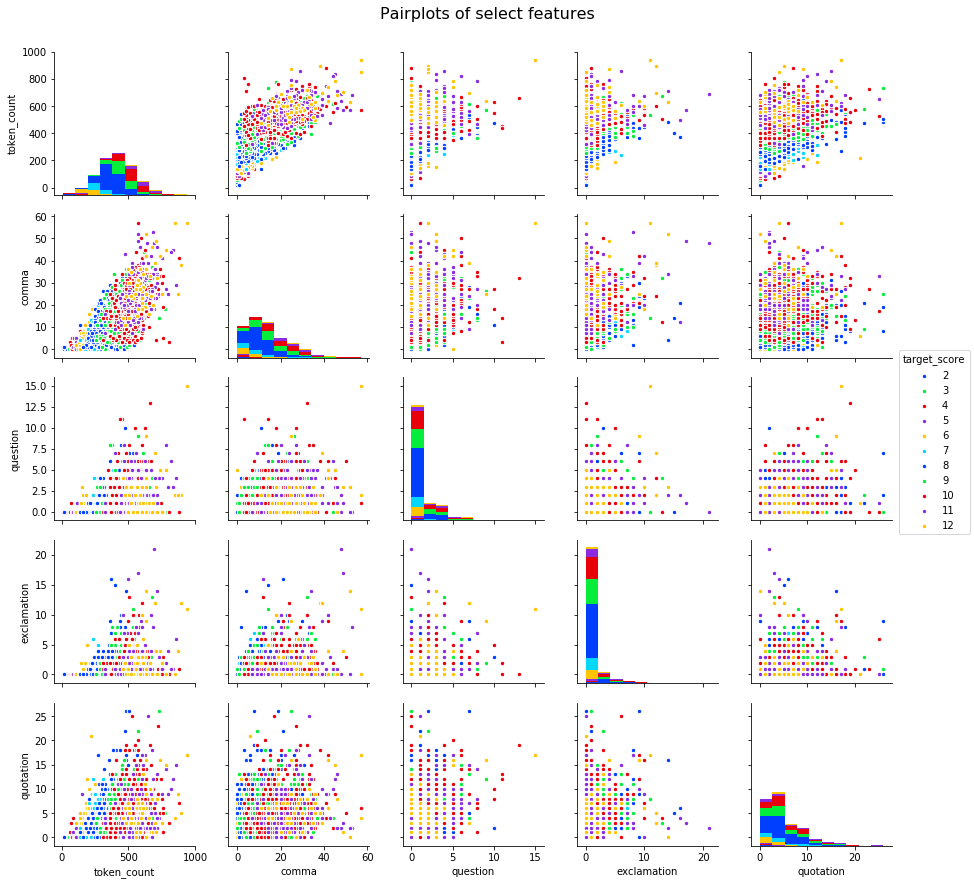

In [191]:
usecols = ['token_count', 'comma', 'question', 'exclamation', 'quotation']
g = sns.pairplot(training_set[training_set.topic == 1], hue='target_score', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show()

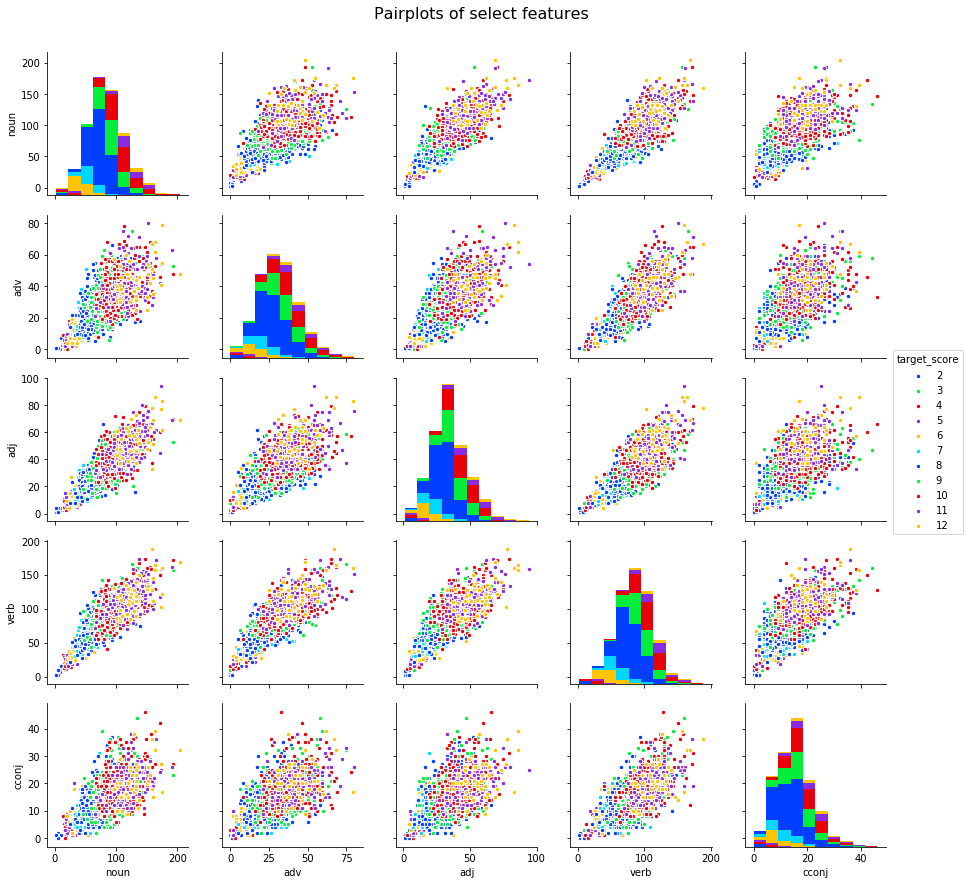

In [196]:
usecols = ['noun', 'adv', 'adj', 'verb', 'cconj']
g = sns.pairplot(training_set[training_set.topic == 1], hue='target_score', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show()

In [184]:
topic = 1

X = training_set[training_set['topic'] == topic][['corrections', 'similarity', 'token_count', 'unique_token_count', 
                'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation',
                'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 
                'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj']]
y = training_set[training_set['topic'] == topic]['target_score']
token_ct = X.token_count
X = X.div(token_ct, axis=0)
X['token_count'] = X['token_count'].mul(token_ct, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)

In [185]:
X.head()

,corrections,similarity,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,organization,caps,person,location,money,time,date,percent,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj
0,0.027778,0.002426,396.0,0.457071,0.462121,0.047980,0.007576,0.045455,0.005051,0.010101,0.017677,0.005051,0.005051,0.000000,0.000000,0.0,0.0,0.002525,0.000000,0.196970,0.075758,0.083333,0.184343,0.035354,0.073232,0.050505,0.012626,0.000000,0.035354,0.002525
1,0.041667,0.002127,456.0,0.451754,0.526316,0.046053,0.032895,0.030702,0.002193,0.002193,0.006579,0.000000,0.004386,0.000000,0.006579,0.0,0.0,0.000000,0.000000,0.210526,0.065789,0.078947,0.210526,0.039474,0.067982,0.076754,0.017544,0.010965,0.017544,0.000000
2,0.029508,0.003139,305.0,0.531148,0.488525,0.052459,0.022951,0.029508,0.000000,0.000000,0.013115,0.003279,0.016393,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.239344,0.068852,0.045902,0.203279,0.052459,0.062295,0.095082,0.009836,0.009836,0.026230,0.000000
3,0.060449,0.001672,579.0,0.459413,0.564767,0.056995,0.025907,0.024180,0.001727,0.003454,0.005181,0.006908,0.034542,0.005181,0.005181,0.0,0.0,0.000000,0.013817,0.227979,0.088083,0.029361,0.196891,0.029361,0.063903,0.077720,0.051813,0.000000,0.024180,0.000000
4,0.032946,0.001878,516.0,0.408915,0.494186,0.058140,0.015504,0.025194,0.000000,0.000000,0.011628,0.000000,0.001938,0.000000,0.003876,0.0,0.0,0.000000,0.000000,0.215116,0.067829,0.048450,0.215116,0.031008,0.085271,0.100775,0.005814,0.007752,0.036822,0.000000


In [186]:
steps = [('scaler', StandardScaler()), ('lm', ElasticNet(l1_ratio=0.1))]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)


0.5422090217951971

In [266]:
from collections import Counter
ttokens = [token for token in t12.iloc[0].tok if token not in stop_words]
# for token in t12.iloc[0].tok:
#     if token not in stop_words:
#         ttokens.append(token)
Counter(ttokens).most_common(10)
len(ttokens)

396

In [ ]:
# from spacy.matcher import Matcher
# import re

# nlp = spacy.load('en_core_web_sm')
# matcher = Matcher(nlp.vocab)

In [58]:
# add match ID "HelloWorld" with no callback and one pattern
# pattern = [{'LOWER': 'hello'}, {'IS_PUNCT': True}, {'LOWER': 'world'}]
# matcher.add('HelloWorld', None, pattern)
regex_pattern = r'@CAPS\d+'
# token_pattern = [{'NORM': '@'}, {'ORTH': 'CAPS'} , {'IS_DIGIT': True}, {'ORTH': 'CAPS'}]

matcher.add('JEFF', None, regex_pattern)
doc = nlp(u'Hello My name is Joshua Bell and I am @CAPS1 or maybe @CAPS22')
matches = matcher(doc)
print(matches)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # get string representation
    span = doc[start:end]  # the matched span
    print(match_id, string_id, start, end, span.text)

AttributeError: 'str' object has no attribute 'items'

In [113]:
import re

nlp = spacy.load('en_core_web_sm')
caps_flag = lambda text: bool(re.compile(r'@CAPS\d+').match(text))
IS_CAPSJ = nlp.vocab.add_flag(definitely_flag)

matcher = Matcher(nlp.vocab)
matcher.add('DEFINITELY2', None, [{IS_CAPSJ: True}])

doc = nlp(u'Hello My name is Joshua Bell and I am @CAPS1 or maybe @CAPS22. I love to play the violin')
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    label = doc.ents
    print(span.text, label)

@CAPS1 (Joshua Bell,)
@CAPS22 (Joshua Bell,)


In [81]:
ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
print(ents)

[]


In [117]:
for token in doc.sents:
    print(token.text)

Hello My name is Joshua Bell
and I am @CAPS1 or maybe @CAPS22.
I love to play the violin


In [111]:
lexeme = nlp.vocab['meanwhile']
lexeme.is_stop

True

In [67]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [ ]:
essays_topic2 = []

for score in range(1, 7):
    essays_topic2.append(training_set[(training_set['topic'] == 2) \
                               & (training_set['target_score'] == score)]\
                              ['tokens']\
                              .astype('unicode')\
                              .sum()[:400000]) # limitation of TfidfVectorizer

In [ ]:
def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [19]:
t12_df = training_set[training_set.topic < 2]
t12_df.shape

(1783, 33)

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
spell = SpellChecker()
spell.word_frequency.load_words(['websites', 'myspace', 'facebook', 'guaranteed', 'conveniences', 'convenient', 'website'])

In [ ]:
# find those words that may be misspelled
misspelled = spell.unknown(essay_list[1])

for word in misspelled:
    # Get the one `most likely` answer
    print(word, '-->', spell.correction(word))

    # Get a list of `likely` options
#     print(spell.candidates(word))

In [ ]:
# t2 = training_set[training_set.topic == 2]['essay']
essays = training_set[training_set.topic < 4]['essay']
essay_list = []

for i, essay in enumerate(essays):
    # do some pre-processing and return list of words for each essay
    essay_list.append(simple_preprocess(essay))
print(i, 'essays preprocessed.')

In [ ]:
# train model with essay
model = Word2Vec(training_set.tokens, min_count=1)

# get vector data
X = model.wv
Xv = model.wv.vectors
del model
print(len(Xv))

In [ ]:
X.vocab

In [ ]:
X.similarity('magazine', 'book')

In [ ]:
X.similarity('newspaper', 'computer')

In [ ]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(Xv, assign_clusters=True)
print (assigned_clusters)
 
words = list(X.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))
 
 
 
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(Xv)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(Xv))
 
silhouette_score = metrics.silhouette_score(Xv, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
Y = tsne.fit_transform(X.vectors[0:80,:])

plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(X.index2word, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()


In [ ]:
l = linkage(X.vectors, method='complete', metric='seuclidean')

In [ ]:
# calculate full dendrogram
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    truncate_mode='level', 
    p=2,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(X.index2word[v])
)
plt.show()

In [ ]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(essays) #fit the vectorizer to essays

print(tfidf_matrix.shape)

In [ ]:
tfidf_matrix

In [ ]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [ ]:
kmeans = KMeans(n_clusters=6, init='random')

kmeans.fit(tfidf_matrix)

clusters = kmeans.labels_.tolist()

In [ ]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
labels = [0, 1, 2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(6, 6))
ax = dendrogram(linkage_matrix, truncate_mode='level', p=0, show_contracted=False, orientation="right", labels=clusters);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.tight_layout() #show plot with tight layout
plt.show()

In [ ]:
# principal component analysis

pca = PCA(n_components=2)

components = pca.fit_transform(dist)

fig, ax = plt.subplots(figsize=(5,5))

g = ax.scatter(components[:,0], components[:,1], label=labels, c=labels, s=100, cmap=plt.cm.get_cmap('tab10', 6))
ax.set_title('Principal Component Analysis')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

# label points
for i, txt in enumerate(labels):
    ax.annotate(txt, (components[i,0],components[i,1]), xytext=(5, 5), textcoords='offset points',)

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: labels[val])
plt.colorbar(g, ax=ax, ticks=[0, 1, 2, 3, 4, 5], format=formatter);

# # Set the clim so that labels are centered on each block
g.set_clim(vmin=-0.5, vmax=5.5)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
essaybag = training_set[training_set['topic'] == 2]['lemma'].astype('unicode').tolist()
labels = training_set[training_set['topic'] == 2]['target_score'].tolist()

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(essaybag) #fit the vectorizer to essays

print(tfidf_matrix.shape)

dist = 1 - cosine_similarity(tfidf_matrix)

# principal component analysis

pca = PCA(n_components=2)

components = pca.fit_transform(dist)



In [ ]:
label_set = np.array(list(set(labels)))

fig, ax = plt.subplots(figsize=(8,8))

g = ax.scatter(components[:,0], components[:,1], label=labels, c=labels, s=5, cmap=plt.cm.get_cmap('tab10', 6))
ax.set_title('Principal Component Analysis')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

# # label points
# for i, txt in enumerate(labels):
#     ax.annotate(txt, (components[i,0],components[i,1]), xytext=(5, 5), textcoords='offset points',)

# # This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: label_set[val])
plt.colorbar(g, ax=ax, ticks=[0, 1, 2, 3, 4, 5], format=formatter);

# # # Set the clim so that labels are centered on each block
g.set_clim(vmin=-0.5, vmax=5.5)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

# Determine semantic similarities
doc1 = nlp(essay1)
doc2 = nlp(essay2)
similarity = doc1.similarity(doc2)
print('')
print('similarity:')
print(similarity)

In [ ]:
training_set[(training_set['essay'].str.len() > 1000)\
             & (training_set['essay'].str.len() < 5050)\
             & (training_set['topic'] == 2)\
             & (training_set['target_score'] == 6)]\
            ['essay']

In [ ]:
sample1 = training_set.loc[2115, 'essay'] 
sample2 = training_set.loc[2913, 'essay'] 

In [ ]:
# Tokenize essay
tokens = word_tokenize(sample1)

# Convert the tokens into lowercase: lower_tokens
lower_tokens = [t.lower() for t in tokens]

# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]

# Remove all stop words: no_stops
stop_words = set(stopwords.words('english'))
no_stops = [t for t in alpha_only if t not in stop_words]

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
# Lemmatize all tokens into a new list: lemmatized
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
# Create the bag-of-words: bow
bow = Counter(lemmatized)
# Print the 10 most common tokens
print(bow.most_common(10))

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

# Process whole documents
text = (sample1)
doc = nlp(sample1)
print(doc)

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

# Determine semantic similarities
doc1 = nlp(sample1)
doc2 = nlp(sample2)
similarity = doc1.similarity(doc2)
print('')
print('similarity:')
print(similarity)

In [ ]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(u'San Francisco considers banning sidewalk delivery robots')
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)
    
from spacy.tokens import Span
doc = nlp(u'FB is hiring a new VP of global policy')
doc.ents = [Span(doc, 0, 1, label=doc.vocab.strings[u'ORG'])]
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
from keras.models import Sequential